In [1]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
import seaborn as sns
from pydicom import dcmread
%matplotlib inline

In [2]:
path = Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic')
Path.BASE_PATH = path
path.ls()

(#6) [Path('test.csv'),Path('train'),Path('train.csv'),Path('test'),Path('osic-pulmonary-fibrosis-progression.zip'),Path('sample_submission.csv')]

In [3]:
train_path = path/'train'
test_path = path/'test'
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sample_sub = pd.read_csv(path/'sample_submission.csv')

In [4]:
#returns a list with the dicoms in order
def dcm_sort(patient_folder):
    #list comprehension that runs through folder of dicoms
    dcm_stacked = [dcmread(dcm) for dcm in patient_folder.ls()]
    dcm_stacked.sort(key=lambda x: int(x.InstanceNumber), reverse=True)
    #returning a python list of dicoms sorted
    return dcm_stacked

#transforms all slices in a scan in hounsfield units 
def ct_transformed(dcm_sorted, threshold=-1000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(np.int16)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [5]:
%%time
dcms = [dcm_sort(folder) for folder in train_path.ls()]

CPU times: user 19 s, sys: 11.5 s, total: 30.6 s
Wall time: 43 s


In [18]:
slice_count = [len(scan) for scan in dcms]
len(slice_count)

176

In [21]:
scan1, scan2, scan3 = dcms[0], dcms[1], dcms[12]
len(scan1), len(scan2), len(scan3)

(67, 451, 233)

In [63]:
img1, img2, img3 = ct_transformed(scan1), ct_transformed(scan2), ct_transformed(scan3)
img1.shape, img2.shape, img3.shape

((67, 512, 512), (451, 512, 512), (233, 512, 512))

Ok we have scans three scans with wildly different numbers of slices

In [27]:
scan1[0].SliceThickness, scan2[0].SliceThickness, scan2[0].Slicehickness

("5.0", "1.0", "1.25")

In [51]:
scan1[0].PixelSpacing, scan2[0].PixelSpacing, scan2[0].PixelSpacing

([0.683, 0.683], [0.740234375, 0.740234375], [0.740234375, 0.740234375])

In [53]:
#We'll have to cast this to a list even though it looks like list above
type(scan1[0].PixelSpacing)

pydicom.multival.MultiValue

In [54]:
[scan1[0].SliceThickness] + list(scan1[0].PixelSpacing)

["5.0", "0.683", "0.683"]

In [57]:
spacing = np.array([scan1[0].SliceThickness] + list(scan1[0].PixelSpacing),
                  dtype=np.float32)

In [65]:
resize_factor = spacing / [1,1,1]
spacing , resize_factor

(array([5.   , 0.683, 0.683], dtype=float32),
 array([5.        , 0.68300003, 0.68300003]))

In [71]:
new_real_shape = img1.shape * resize_factor
img1.shape, new_real_shape

((67, 512, 512), array([335.       , 349.6960144, 349.6960144]))

In [74]:
new_shape = np.round(new_real_shape)
real_resize_factor = new_shape / img1.shape

In [75]:
#real_resize_factor
np.round(new_real_shape) / img1.shape

array([5.        , 0.68359375, 0.68359375])

In [77]:
real_resize_factor - spacing, real_resize_factor - resize_factor

(array([0.        , 0.00059372, 0.00059372]),
 array([0.        , 0.00059372, 0.00059372]))

In [78]:
spacing / real_resize_factor

array([1.        , 0.99913147, 0.99913147])

In [80]:
res_img1 = scipy.ndimage.interpolation.zoom(img1, real_resize_factor,
                                 mode='nearest')

In [81]:
res_img1.shape

(335, 350, 350)

In [83]:
def resample(img, scan, new_spacing=[1,1,1]):
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing),
                      dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / img.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(img, real_resize_factor,
                                        mode='nearest')
    return image, new_spacing

In [85]:
%%time
res_img1, res_1_spacing = resample(img1, scan1)
res_img2, res_2_spacing = resample(img2, scan2)
res_img3, res_3_spacing = resample(img3, scan3)

CPU times: user 55.8 s, sys: 272 ms, total: 56.1 s
Wall time: 56.1 s


In [86]:
res_img1.shape, res_img2.shape, res_img3.shape

((335, 350, 350), (451, 379, 379), (291, 360, 360))

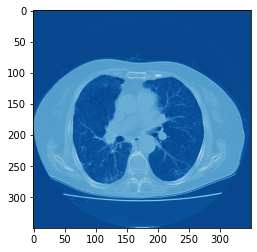

In [90]:
plt.imshow(res_img1[200], cmap='Blues_r')

In [92]:
np.divide(64, res_img1.shape)

array([0.19104478, 0.18285714, 0.18285714])

In [97]:
335*350*350, 451*379*379, 291*360*360

(41037500, 64782091, 37713600)

41 Million, 64 Million and 37 million.... That's way too many pixels still

In [101]:
np.array([32,256,256]) / np.array(img1.shape)

array([0.47761194, 0.5       , 0.5       ])

In [102]:
img1.shape

(67, 512, 512)